In [2]:
# pip install selenium pandas
!pip install beautifulsoup4 requests pandas


In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import time


In [4]:

# Set up ChromeDriver path
chromedriver_path = r'C:\Users\91933\OneDrive\Desktop\demo code\chromedriver-win64\chromedriver.exe'
service = Service(chromedriver_path)
driver = webdriver.Chrome(service=service)

# Navigate to Google Flights URL
url = "https://www.google.com/travel/flights/search?tfs=CBwQAhoqEgoyMDI1LTAyLTAyag0IAxIJL20vMDI3d3Zicg0IAxIJL20vMDFmMDhyGioSCjIwMjUtMDItMjJqDQgDEgkvbS8wMWYwOHJyDQgDEgkvbS8wMjd3dmJAAUgBcAGCAQsI____________AZgBAQ"
driver.get(url)

# Wait for page to load
time.sleep(15)  # Adjust this based on internet speed; increase if required

# Parse the page with BeautifulSoup
html_content = driver.page_source
soup = BeautifulSoup(html_content, 'html.parser')

# Define functions to extract data
def scrape_flight_data(soup):
    flight_listings = soup.select('li.pIav2d')  # Selector for flights list
    data = []

    for listing in flight_listings:
        # Extracting airline name
        airline = listing.select_one('div.Ir0Voe div.sSHqwe')
        airline_name = airline.text.strip() if airline else "Not available"

        # Extracting flight duration
        duration = listing.select_one('div.AdWm1c.gvkrdb')
        flight_duration = duration.text.strip() if duration else "Not available"

        # Extracting price
        price = listing.select_one('div.U3gSDe div.FpEdX span')
        flight_price = price.text.strip() if price else "Not available"

        # Extracting departure and arrival times
        departure_time = listing.select_one('span[aria-label^="Departure time"]')
        arrival_time = listing.select_one('span[aria-label^="Arrival time"]')
        dep_time = departure_time.text.strip() if departure_time else "Not available"
        arr_time = arrival_time.text.strip() if arrival_time else "Not available"

        # Extracting departure and arrival dates
        departure_date = listing.select_one('div[id*="gEvJbfc"] span.eoY5cb')
        dep_date = departure_date.text.split('on')[-1].strip() if departure_date else "Not available"
        arrival_date = listing.select_one('div[id*="gEvJbfc"] span.eoY5cb')
        arr_date = arrival_date.text.split('on')[-1].strip() if arrival_date else "Not available"

        # Extracting departure and arrival airports
        flight_info = listing.select_one('span.mv1WYe[aria-label]')
        if flight_info and flight_info.get('aria-label'):
            info_text = flight_info['aria-label']
            dep_airport = info_text.split('Leaves ')[-1].split(' at ')[0].strip()
            arr_airport = info_text.split('arrives at ')[-1].split(' at ')[0].strip()
        else:
            dep_airport = "Not available"
            arr_airport = "Not available"

        # Extracting stops
        stops = listing.select_one('div.EfT7Ae span.ogfYpf')
        flight_stops = stops.text.strip() if stops else "Non-stop"

        # Extracting CO2 emissions
        co2_emission = listing.select_one('div.V1iAHe div.AdWm1c')
        co2_emission_value = co2_emission.text.strip() if co2_emission else "Not available"

        # Append the extracted data as a dictionary
        data.append({
            "Airline": airline_name,
            "Flight Duration": flight_duration,
            "Price": flight_price,
            "Departure Time": dep_time,
            "Departure Date": dep_date,
            "Departure Airport": dep_airport,
            "Arrival Time": arr_time,
            "Arrival Date": arr_date,
            "Arrival Airport": arr_airport,
            "Stops": flight_stops,
            "CO2 Emissions": co2_emission_value
        })

    return data

# Call the function
flight_data = scrape_flight_data(soup)


# Call the scraping function and convert to a DataFrame
flight_data = scrape_flight_data(soup)
flight_df = pd.DataFrame(flight_data)

# # Save data to CSV or display
# flight_df.to_csv('flight_data.csv', index=False)
# print(flight_df)

# Close the driver
driver.quit()


In [5]:

# Step 6: Scrape the flight data
flight_data = scrape_flight_data(soup)

# Step 7: Convert data to DataFrame
df = pd.DataFrame(flight_data)

# Display the first few rows of the DataFrame
print(df.head())


  Airline Flight Duration    Price Departure Time Departure Date  \
0  IndiGo    11 hr 30 min  ₹27,515        8:45 AM     Sun, Feb 2   
1  IndiGo    11 hr 15 min  ₹28,349       12:40 PM     Sun, Feb 2   
2  IndiGo     8 hr 15 min  ₹29,252        4:35 PM     Sun, Feb 2   
3  IndiGo    25 hr 40 min  ₹27,351        9:30 PM     Sun, Feb 2   
4  IndiGo    25 hr 45 min  ₹27,515        6:30 PM     Sun, Feb 2   

                                 Departure Airport Arrival Time Arrival Date  \
0  Jayprakash Narayan International Airport, Patna      6:45 PM   Sun, Feb 2   
1  Jayprakash Narayan International Airport, Patna     10:25 PM   Sun, Feb 2   
2  Jayprakash Narayan International Airport, Patna     11:20 PM   Sun, Feb 2   
3  Jayprakash Narayan International Airport, Patna    9:40 PM+1   Sun, Feb 2   
4  Jayprakash Narayan International Airport, Patna    6:45 PM+1   Sun, Feb 2   

               Arrival Airport   Stops CO2 Emissions  
0  Zayed International Airport  1 stop   266 kg CO2e  


In [6]:

# Step 8: Save data to a CSV file
output_file = 'google_flights_data.csv'
df.to_csv(output_file, index=False)
print(f"Data successfully saved to {output_file}")

# Step 9: Close the browser
driver.quit()

Data successfully saved to google_flights_data.csv


Till here data scraping done successfully

Data cleaning and visualization

In [7]:
# Load the data
file_path = "google_flights_data.csv"
df = pd.read_csv(file_path)

# Process "Arrival Time" column
if 'Arrival Time' in df.columns:
    df['Next Day Dispatcher'] = df['Arrival Time'].apply(lambda x: 1 if '+1' in str(x) else 0)
    df['Arrival Time'] = df['Arrival Time'].str.replace('+1', '').str.strip()

# Process "Price" column
if 'Price' in df.columns:
    unavailable_price_df = df[df['Price'].str.contains('unavailable', case=False, na=False)]
    unavailable_price_df.to_csv("price_unavailable_data.csv", index=False)
    df = df[~df['Price'].str.contains('unavailable', case=False, na=False)]


In [8]:
# Save the cleaned dataset
x=df.to_csv("cleaned_google_flights_data.csv", index=False)

In [9]:
df.head(x)

,Airline,Flight Duration,Price,Departure Time,Departure Date,Departure Airport,Arrival Time,Arrival Date,Arrival Airport,Stops,CO2 Emissions,Next Day Dispatcher
0,IndiGo,11 hr 30 min,"₹27,515",8:45 AM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",6:45 PM,"Sun, Feb 2",Zayed International Airport,1 stop,266 kg CO2e,0
1,IndiGo,11 hr 15 min,"₹28,349",12:40 PM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",10:25 PM,"Sun, Feb 2",Zayed International Airport,1 stop,257 kg CO2e,0
2,IndiGo,8 hr 15 min,"₹29,252",4:35 PM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",11:20 PM,"Sun, Feb 2",Zayed International Airport,1 stop,230 kg CO2e,0
3,IndiGo,25 hr 40 min,"₹27,351",9:30 PM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",9:40 PM,"Sun, Feb 2",Zayed International Airport,1 stop,266 kg CO2e,1
4,IndiGo,25 hr 45 min,"₹27,515",6:30 PM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",6:45 PM,"Sun, Feb 2",Zayed International Airport,1 stop,266 kg CO2e,1
...,...,...,...,...,...,...,...,...,...,...,...,...
126,IndiGo,16 hr 25 min,"₹40,666",8:20 PM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",11:15 AM,"Sun, Feb 2",Dubai International Airport,1 stop,245 kg CO2e,1
127,IndiGo,15 hr 25 min,"₹40,666",9:20 PM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",11:15 AM,"Sun, Feb 2",Dubai International Airport,1 stop,233 kg CO2e,1
128,IndiGo,26 hr,"₹41,558",10:45 AM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",11:15 AM,"Sun, Feb 2",Dubai International Airport,1 stop,233 kg CO2e,1
129,IndiGo,24 hr 55 min,"₹41,558",11:50 AM,"Sun, Feb 2","Jayprakash Narayan International Airport, Patna",11:15 AM,"Sun, Feb 2",Dubai International Airport,1 stop,233 kg CO2e,1


In [10]:
!pip install matplotlib seaborn

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# Load the cleaned data
cleaned_data_path = "cleaned_google_flights_data.csv"
df = pd.read_csv(cleaned_data_path)


In [13]:
# Check the first few rows and column information
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airline              112 non-null    object
 1   Flight Duration      112 non-null    object
 2   Price                112 non-null    object
 3   Departure Time       112 non-null    object
 4   Departure Date       112 non-null    object
 5   Departure Airport    112 non-null    object
 6   Arrival Time         112 non-null    object
 7   Arrival Date         112 non-null    object
 8   Arrival Airport      112 non-null    object
 9   Stops                112 non-null    object
 10  CO2 Emissions        112 non-null    object
 11  Next Day Dispatcher  112 non-null    int64 
dtypes: int64(1), object(11)
memory usage: 10.6+ KB
None


In [14]:
print(df.describe())

       Next Day Dispatcher
count           112.000000
mean              0.785714
std               0.412170
min               0.000000
25%               1.000000
50%               1.000000
75%               1.000000
max               1.000000


In [15]:

# 1. Fix "Departure Date" and "Arrival Date"
# Define the custom format for parsing the date
date_format = "%a, %b %d"
df['Departure Date'] = pd.to_datetime(df['Departure Date'], format=date_format, errors='coerce')
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], format=date_format, errors='coerce')

# Handle cases where the year is missing
# Assuming all flights occur in the current year or next year
df['Departure Date'] = df['Departure Date'].apply(lambda x: x.replace(year=2025) if pd.notnull(x) else x)
df['Arrival Date'] = df['Arrival Date'].apply(lambda x: x.replace(year=2025) if pd.notnull(x) else x)

# 2. Combine Date and Time for "Departure" and "Arrival"
df['Departure DateTime'] = pd.to_datetime(
    df['Departure Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Departure Time'], errors='coerce'
)
df['Arrival DateTime'] = pd.to_datetime(
    df['Arrival Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Arrival Time'], errors='coerce'
)

# 3. Convert "Price" to numerical
df['Price'] = df['Price'].replace('[₹,]', '', regex=True).astype(float)

# 4. Convert "CO2 Emissions" to numerical
df['CO2 Emissions'] = df['CO2 Emissions'].replace('[kg CO2e]', '', regex=True).astype(float)

# 5. Convert "Flight Duration" to total minutes
def convert_duration(duration):
    parts = duration.split(' ')
    hours = int(parts[0]) * 60  # Convert hours to minutes
    minutes = int(parts[2]) if len(parts) > 2 else 0
    return hours + minutes

df['Flight Duration (mins)'] = df['Flight Duration'].apply(convert_duration)

# 6. Clean the "Stops" column (e.g., "1 stop" -> 1)
df['Stops'] = df['Stops'].str.extract('(\\d)').astype(int)  # Correct the escape sequence

# Display the cleaned data
print(df.head())


  Airline Flight Duration    Price Departure Time Departure Date  \
0  IndiGo    11 hr 30 min  27515.0        8:45 AM     2025-02-02   
1  IndiGo    11 hr 15 min  28349.0       12:40 PM     2025-02-02   
2  IndiGo     8 hr 15 min  29252.0        4:35 PM     2025-02-02   
3  IndiGo    25 hr 40 min  27351.0        9:30 PM     2025-02-02   
4  IndiGo    25 hr 45 min  27515.0        6:30 PM     2025-02-02   

                                 Departure Airport Arrival Time Arrival Date  \
0  Jayprakash Narayan International Airport, Patna      6:45 PM   2025-02-02   
1  Jayprakash Narayan International Airport, Patna     10:25 PM   2025-02-02   
2  Jayprakash Narayan International Airport, Patna     11:20 PM   2025-02-02   
3  Jayprakash Narayan International Airport, Patna      9:40 PM   2025-02-02   
4  Jayprakash Narayan International Airport, Patna      6:45 PM   2025-02-02   

               Arrival Airport  Stops  CO2 Emissions  Next Day Dispatcher  \
0  Zayed International Airport   

C:\Users\91933\AppData\Local\Temp\ipykernel_5024\85227602.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arrival DateTime'] = pd.to_datetime(


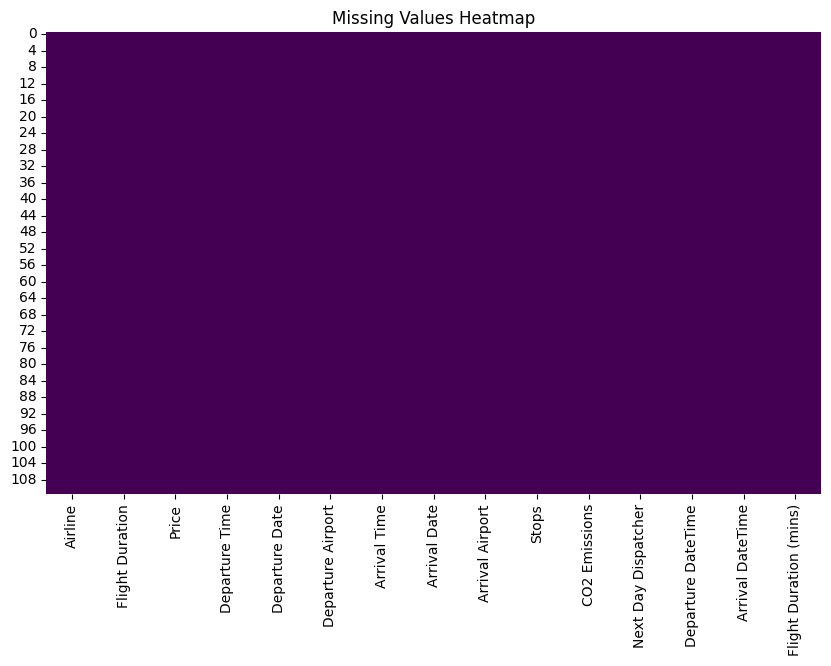

In [16]:
# Visualize missing values with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


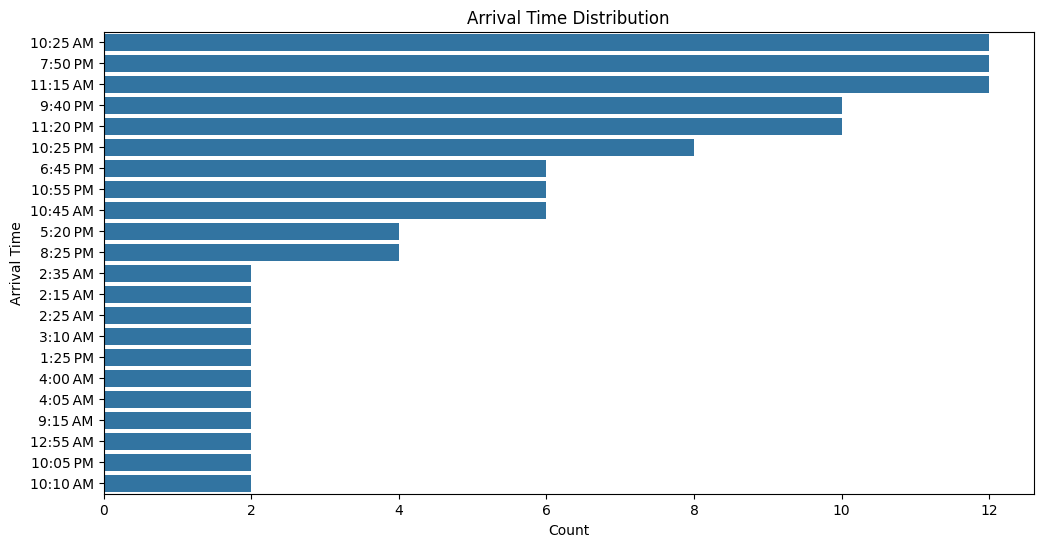

In [17]:
# Visualize the count of each arrival time (if categorical)
if 'Arrival Time' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(y='Arrival Time', data=df, order=df['Arrival Time'].value_counts().index)
    plt.title("Arrival Time Distribution")
    plt.ylabel("Arrival Time")
    plt.xlabel("Count")
    plt.show()


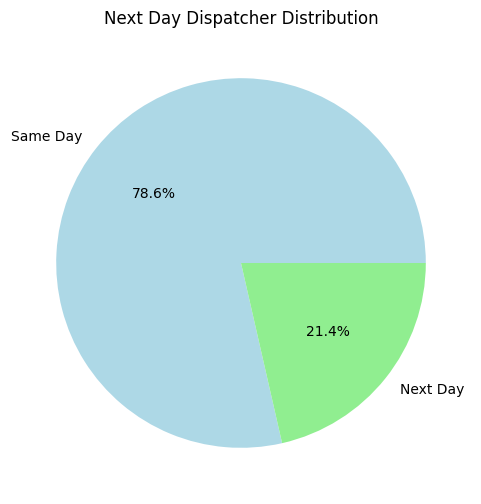

In [18]:
if 'Next Day Dispatcher' in df.columns:
    plt.figure(figsize=(6, 6))
    df['Next Day Dispatcher'].value_counts().plot.pie(autopct="%1.1f%%", labels=["Same Day", "Next Day"], colors=["lightblue", "lightgreen"])
    plt.title("Next Day Dispatcher Distribution")
    plt.ylabel("")
    plt.show()


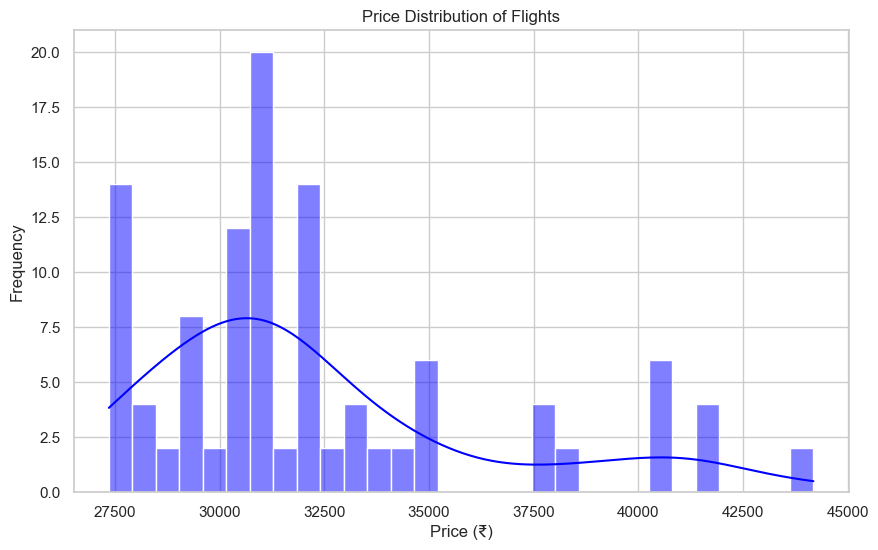

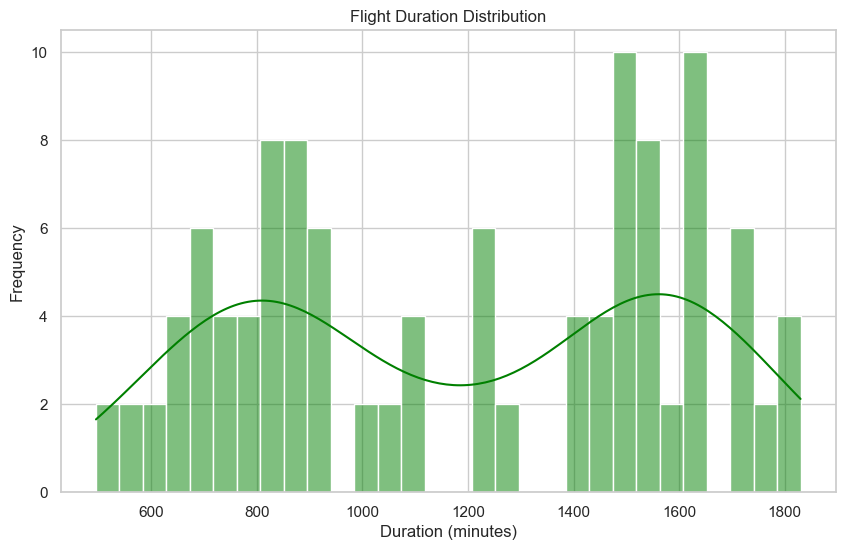

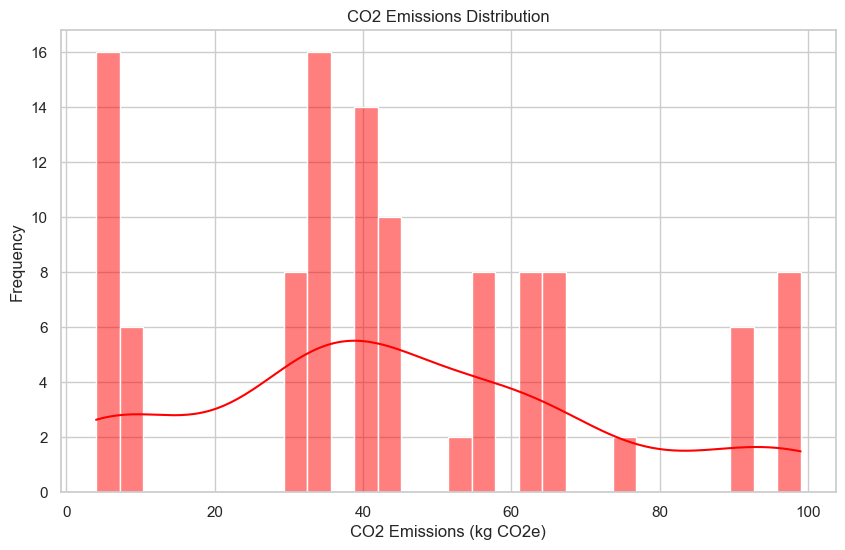

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Price distribution (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, color='blue', bins=30)
plt.title('Price Distribution of Flights')
plt.xlabel('Price (₹)')
plt.ylabel('Frequency')
plt.show()

#Flight Duration distribution (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['Flight Duration (mins)'], kde=True, color='green', bins=30)
plt.title('Flight Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

# CO2 Emissions distribution (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['CO2 Emissions'], kde=True, color='red', bins=30)
plt.title('CO2 Emissions Distribution')
plt.xlabel('CO2 Emissions (kg CO2e)')
plt.ylabel('Frequency')
plt.show()



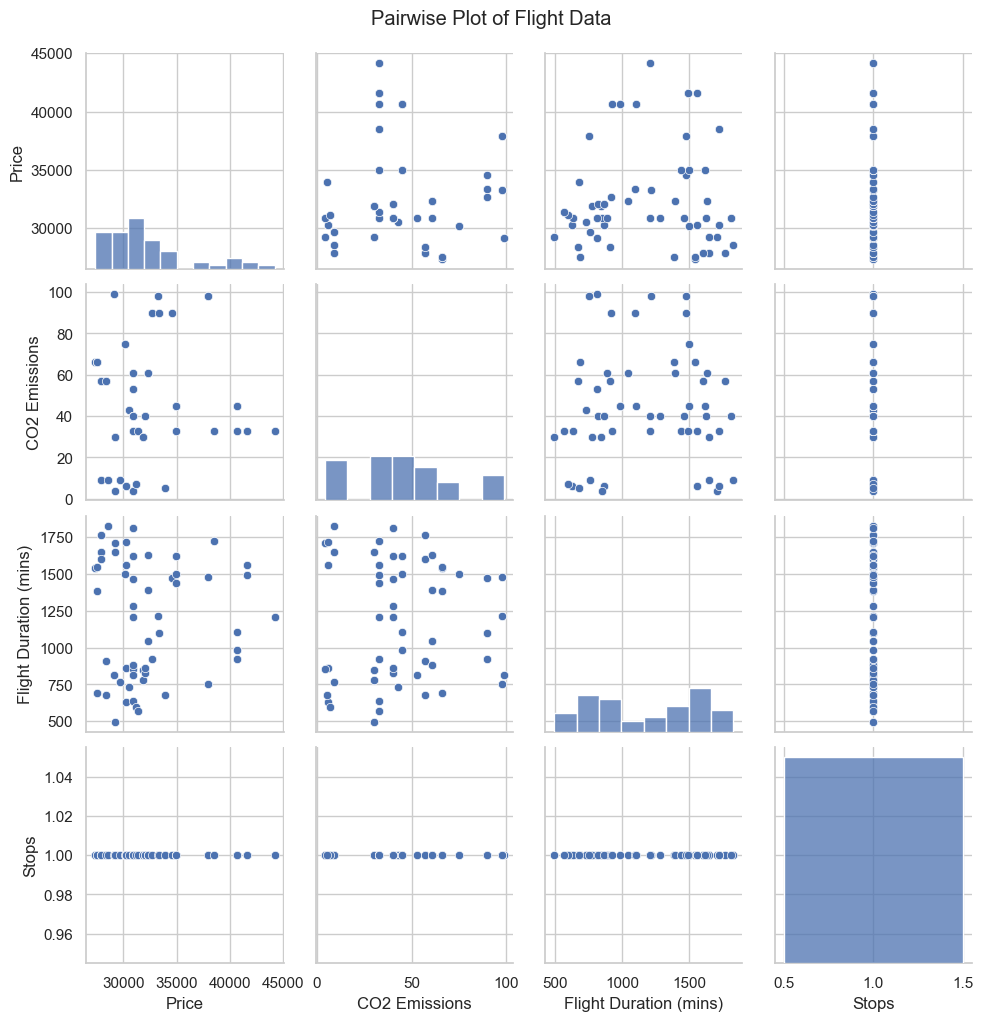

In [20]:
# 3. Pairplot for Multiple Variables
sns.pairplot(df[['Price', 'CO2 Emissions', 'Flight Duration (mins)', 'Stops']])
plt.suptitle('Pairwise Plot of Flight Data', y=1.02)
plt.show()


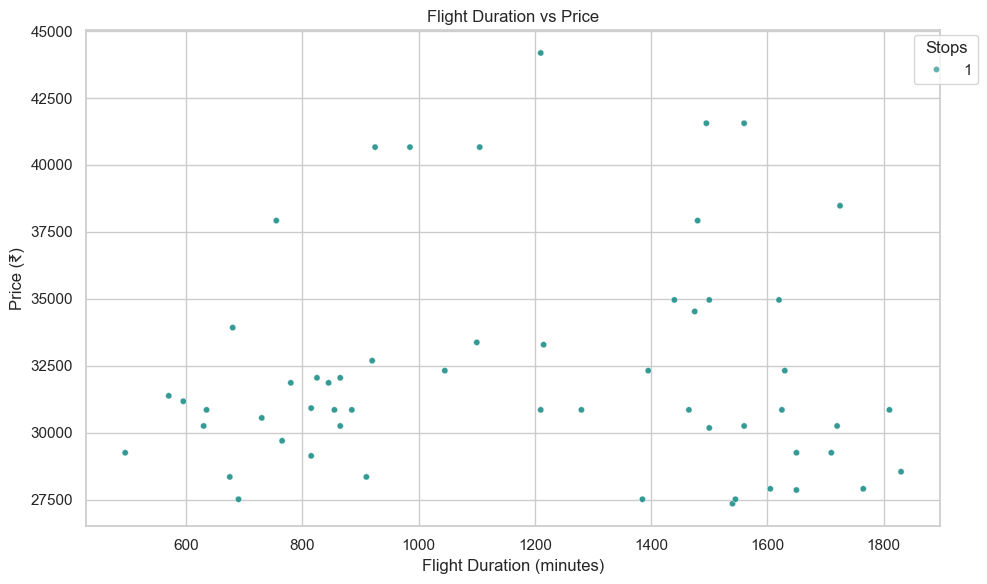

In [21]:
# Improved 8. Flight Duration vs Price (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Flight Duration (mins)', y='Price', hue='Stops', palette='viridis', size='Stops', sizes=(20, 200), alpha=0.7, edgecolor='w')
plt.title('Flight Duration vs Price')
plt.xlabel('Flight Duration (minutes)')
plt.ylabel('Price (₹)')
plt.legend(title='Stops', loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.3)
plt.tight_layout()
plt.show()


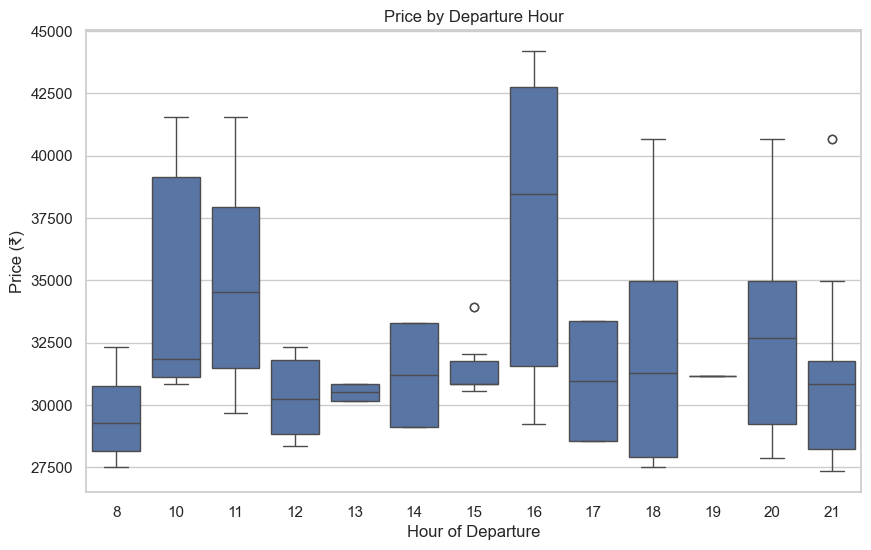

In [22]:
# 6. Departure Time vs. Price
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x=df['Departure DateTime'].dt.hour, y='Price')
plt.title("Price by Departure Hour")
plt.xlabel("Hour of Departure")
plt.ylabel("Price (₹)")
plt.show()



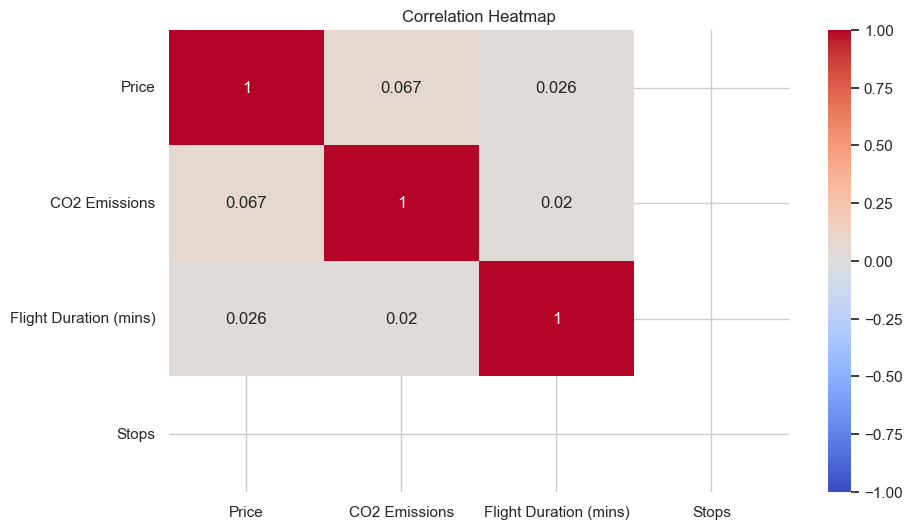

In [23]:
# 2. Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = df[['Price', 'CO2 Emissions', 'Flight Duration (mins)', 'Stops']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


Still working for further for future work link collecting more data, Data cleaning, visualization and implmenting ML/DL model for prediction like missing flight price etc.